# Quantum Monte Carlo on Quantum Computers

In computational chemistry and material science, we are often interested in finding the ground-state energy (i.e., minimum energy) of a molecule or solid for a given configuration of atomic positions. A range of different methods have been developed to solve the electronic structure problem; each with their own efficiency and accuracy tradeoffs. Important methods include mean-field approaches, such as Hartree-Fock theory (HF) and density functional theory (DFT), which can scale to large system sizes, but are not sufficiently accurate for strongly correlated systems. More sophisticated methods, such as coupled cluster theory (CC) or configuration interaction (CI) take electron correlations into account to achieve better accuracy. However, this comes at a high computational cost that makes it prohibitive to apply these methods to large systems.

Quantum Monte Carlo (QMC) methods [1] are a class of techniques that solve the electronic structure problem by applying probabilistic sampling of the target wavefunction. This sampling reduces the time and memory costs of the algorithm, but introduces an infamous 'sign-problem' that causes the variance of the sampled signal to grow exponentially with the system size. QMC methods include variational Monte Carlo (VMC), Green's function Monte Carlo (GFMC) and auxiliary-field QMC (AFQMC). To improve the efficiency of sampling and mitigate the sign-problem, one can perform importance sampling using a trial state $|\Psi_T\rangle$ that approximates the true ground state. The ability of $|\Psi_T\rangle$ to approximate the target ground state $|\Psi_0\rangle$ thus determines the accuracy of the QMC calculation. Limitations of QMC on classical computers include the following:
* The estimated ground state energy may have a large bias from the true energy.
* The ground state energy may have a large statistical variance, due to the sign-problem.

In this notebook, we demonstrate how to augment classical QMC calculations using quantum computers using AFQMC [2]. In particular, we discuss how quantum computers can be used to ameliorate the challenges discussed above. Compared to the variational quantum eigensolver (VQE) [3], a popular quantum algorithm for solving the electronic structure problem, QC‑AFQMC does not require an expensive optimization loop. The circuit depth of both methods is similar.

This notebook is organized as follows. First, we provide theoretical background on how the AFQMC method works. Second, we show how quantum computers can be used to augment AFQMC calculations, explicitly showcasing the quantum subroutines using the PennyLane simulator in Amazon Braket. Finally, we present an example AFQMC calculation to find the ground state of H$_2$ molecule. The code can be run on both classical simulators and quantum computers.

<div class="alert alert-block alert-info">
<b>Note:</b> To achieve peak performance, this notebook requires a specific version of Braket and PennyLane. Install the packages by running the next cell. The code in this notebook has option to use multiprocessing for computations. A notebook instance with multiple CPU cores is required to use multiprocessing. With a ml.m5.24xlarge notebook instance, the code takes about 6 minutes in total to run in this notebook, which will incur charge for about \$0.6 USD. The notebook also creates a Braket job to compute a scaled-up QMC workload that takes about 30 minutes with a ml.m5.24xlarge job instance, which will incur charge for about \$2.8 USD.
</div>

In [1]:
# Install packages

!pip --disable-pip-version-check --quiet install -r afqmc/requirements.txt

In [2]:
import multiprocessing as mp
import time
from itertools import product

import numpy as np
import pennylane as qml
from scipy.linalg import expm

np.set_printoptions(precision=4, edgeitems=10, linewidth=150, suppress=True)

## Part I. Auxiliary-Field Quantum Monte Carlo

A suitable approach to find the ground state of a chemical system is to evolve the system in imaginary time, which causes the excited states to decay, leaving just the ground state. We want to implement the imaginary time evolution as:

$$
|\Psi\rangle \propto e^{-\tau (H-E_0)} |\Psi_I\rangle = \lim_{n \to \infty} \left[e^{-\triangle\tau(H-E_0)}\right]^n |\Psi_I\rangle,
$$

where $|\Psi_I\rangle$ is the initial state, $E_0$ is an energy shift chosen to approximate the ground state energy, and $H$ is the second quantized Hamiltonian specifically written as
$$
H = H_0 + \hat{v}_0 - \frac{1}{2}\sum_{\gamma} \hat{v}_{\gamma}^2
$$

where $\hat{v}_0$ and $\hat{v}_{\gamma}$ are one-body fermionic operators (see [Appendix A](#Appendix_A) for more details about the form of the Hamiltonian). Since a direct implementation of the imaginary time evolution is difficult due to the two-body terms ($\hat{v}^2_{\gamma}$), the AFQMC algorithm maps the original interacting system onto an ensemble of non-interacting systems coupled to a set of random auxiliary fields $\textbf{x}$ using the Hubbard-Stratonovich (HS) transformation

$$
e^{\frac{\triangle\tau}{2} \hat{v}_{\gamma}^2} = \int dx_{\gamma} \frac{1}{\sqrt{2\pi}}e^{-x_{\gamma}^2/2} e^{\sqrt{\triangle\tau} x_{\gamma} \hat{v}_{\gamma}}.
$$

For a detailed derivation of the imaginary time evolution, we direct the reader to [Appendix B](#Appendix_B). Rather than analytically calculating the resulting integrals, AFQMC approximates the non-interacting imaginary time evolution by stochastically sampling the integral, and considering a finite ensemble of non-interacting states - known as walkers. The walker states will stay on the manifold of Slater determinant states during the imaginary time evolution. The evolution of every walker state is independent, which makes this step easily parallelizable. A schematic representation of the walkers propagating on the energy landscape to obtain the ground state energy is shown in the following picture.

<img src="images/visualwalkers.png" width="600" />

As discussed in the introduction, the sampling of walkers can lead to the infamous sign problem, where the signal of QMC vanishes compared to the noise fluctuations. This sign problem is largely removed by a phaseless approximation [2] by using the trial state, which allows us to stochastically sample the walkers that are most prominent in the (approximate) ground state wavefunction. The quality of this approximation largely depends on the chosen trial wave function and may introduce a bias in the final converged energy estimate. This sampling is performed by evaluating the overlap integral and the corresponding energy between a walker and the trial state

$$
\langle \Psi_T | \phi_l \rangle,\;\;\;\;\langle \Psi_T | H | \phi_l \rangle.
$$

Evaluating the overlap is the key step of AFQMC that benefits from the use of quantum computing resources.

On classical computers, the trial state $|\Psi_C\rangle$, is usually chosen either as a mean-field state (e.g., from HF or DFT calculations), or as a linear combination of mean-field states (e.g., from a CI expansion). This ensures the overlap integral between a walker state and the tiral state can be efficiently calculated on a classical computer. In the classical calculations implemented in this notebook, we will choose the trial state to be the HF state, e.g., $|\Psi_C\rangle = |\Psi_{\text{HF}}\rangle$.

We will discuss in the next section how augmenting the classical AFQMC algorithm with quantum resources enables the use of a broader class of trial states, which may provide better importance sampling from the ground state.

## Part II. Quantum-Assisted QMC algorithms

How can we use quantum computers in the AFQMC algorithm? As we discussed earlier, the classical trial state $|\Psi_C\rangle$ is limited to a small class of states, i.e., either mean-field states (HF or DFT) or a linear combination of mean-field states. With quantum computers, we can choose from a much wider range of states $|\Psi_T\rangle = |\Psi_Q\rangle$, e.g., unitary coupled-cluster (UCC) -type states [3], which are believed to be exponentially hard to represent on classical computers. These quantum states could be obtained from a VQE pre-calculation.


We can replace $|\Psi_C\rangle$ with $|\Psi_Q\rangle$ to perform a quantum-assisted QMC calculation [4,5]. Specifically we use new trial state when propagating the walkers and evaluating the energy, while the other steps in the algorithm are unchanged. To carry out the algorithm, we need to evaluate both the amplitude $\langle\Psi_Q|\phi_l\rangle$ and the local energy $\langle\Psi_Q|H|\phi_l\rangle$ for all walker states $|\phi_l\rangle$. Both quantities can be efficiently estimated on quantum computers using the vacuum reference circuit [5] shown below, where $V_T$ represents the unitary to prepare the $|\Psi_Q\rangle$ and $V_{\phi}$ represents the unitary to prepare $|\phi_l\rangle$.

<img src="images/vacuum_reference.png" width="800" />

As the walker state is a Slater determinant, it can be prepared using a Givens rotation circuit [6]. We use the notation $n_p$ to represent the number of electrons, and $n_q$ to represent the number of spin-orbitals. The Jordan-Wigner transformation is used to map spin-orbitals to qubits. 

We discuss the ingredients for performing QC-AFQMC.

### Step I. Define quantum trial state $|\Psi_Q\rangle$

The UCC ansatz is an extension of coupled-cluster (CC) theory. In the UCC method, the parameterized trial function is given by $U(\vec{\theta}) = e^{\hat{T} - \hat{T}^\dagger}$, where $\hat{T}$ is a sum of excitation operators. The UCC method is able to converge when applied to multi-reference states, unlike the regular CC approach. As in CC, we truncate the expression for $\hat{T}$ at a given excitation level — usually single and double excitations leading to the UCCSD ansatz. An optimized circuit that has the same effect as the UCCSD ansatz for H$_2$ is shown in the following figure (This figure is taken from Ref [9]).

<img src="images/ucc.png" width="700" />

In [3]:
# define the UCCSD ansatz circuit


def V_T():
    qml.RX(np.pi / 2.0, wires=0)
    for i in range(1, 4):
        qml.Hadamard(wires=i)

    for i in range(3):
        qml.CNOT(wires=[i, i + 1])

    qml.RZ(0.12, wires=3)  # here we assign the parameter
    for i in range(3)[::-1]:
        qml.CNOT(wires=[i, i + 1])

    qml.RX(-np.pi / 2.0, wires=0)
    for i in range(1, 4):
        qml.Hadamard(wires=i)


# printing the circuit for quantum trial state
@qml.qnode(qml.device("lightning.qubit", wires=4))
def V_T_print():
    V_T()
    return qml.state()


print(qml.draw(V_T_print)())

0: ──RX(1.57)─╭C───────────────────────╭C──RX(-1.57)─┤  State
1: ──H────────╰X─╭C─────────────────╭C─╰X──H─────────┤  State
2: ──H───────────╰X─╭C───────────╭C─╰X──H────────────┤  State
3: ──H──────────────╰X──RZ(0.12)─╰X──H───────────────┤  State


### Step II. Preparing arbitrary Slater determinant on QC with Givens rotations

An arbitrary Slater determinant state can be transformed back to the HF state using a circuit composed of Givens rotations. A Givens rotation is a $2 \times 2$ matrix given by

$$
G(\theta, \varphi) = \begin{pmatrix}
\cos\theta & -e^{i\varphi}\sin\theta\\
\sin\theta & e^{i\varphi}\cos\theta
\end{pmatrix}.
$$

We adopt the same convention as Openfermion and [6], where the lowest spin-orbital is labeled with the "0" qubit index $(q_0, q_1, ...)$. In this case, we embed a Givens rotation matrix in the two-qubit space as

$$
G(\theta, \varphi) = \begin{pmatrix}
1 & 0 & 0 & 0\\
0 & e^{i\varphi}\cos\theta & \sin\theta & 0\\
0 & -e^{i\varphi}\sin\theta & \cos\theta & 0\\
0 & 0 & 0 & e^{i\varphi}
\end{pmatrix}.
$$

We implement a Givens rotation gate between adjacent orbitals using the following quantum circuit

<img src="images/Givens.png" width="600" />

The Slater determinant circuit is generated by finding the sequence of Givens rotation that diagonalize the matrix $Q$ representing the given Slater determinant. Specifically, we seek to transform $Q$ into a $m \times n$ matrix $D$ with the first $m$ columns forming a diagonal matrix and the rest of the columns being zero.

We implement this procedure in the following example.

In [4]:
##############################################################
# We import necessary functions to prepare the walker state  #
##############################################################

from afqmc.quantum_afqmc import prepare_slater_circuit, reortho

In [5]:
########################################################################################################
# We perform an example calculation to prepare an arbitrary Slater determinant of a one-electron case  #
########################################################################################################

from openfermion.circuits.slater_determinants import slater_determinant_preparation_circuit

# this state is already normalized, if not this can be done by reorthonormalising.
random_SD = np.array([[0.8], [0.6j]])

# then we obtain a circuit description, which consists of the parameters for the Givens rotations
circuit_description = slater_determinant_preparation_circuit(random_SD.T)

# finally we can prepare this Slater determinant starting from HF state.
dev = qml.device("lightning.qubit", wires=2)


@qml.qnode(dev)
def prepare_random_slater(circuit_description):
    qml.PauliX(0)
    prepare_slater_circuit(circuit_description)
    return qml.state()


sv = prepare_random_slater(circuit_description).reshape((4, 1))
print(f"The prepared state using Givens rotation is \n {np.round(sv/(sv[2]/abs(sv[2])), 4)}.")

# the circuit has the following form:
print(qml.draw(prepare_random_slater)(circuit_description))

The prepared state using Givens rotation is 
 [[ 0. +0.j ]
 [-0. +0.6j]
 [ 0.8+0.j ]
 [ 0. +0.j ]].
0: ──X─╭X─╭C───────────╭C────────────╭X────────────┤  State
1: ────╰C─╰X──RY(0.64)─╰X──RY(-0.64)─╰C──RZ(-1.57)─┤  State


### Step III. Compute $\langle\Psi_Q|\phi_l\rangle, \langle\Psi_Q|H|\phi_l\rangle$ with low rank decomposition of Hamiltonian


Here we discuss a way to estimate $\langle\Psi_Q|H|\phi_l\rangle$ using the amplitude vacuum reference circuit. $\langle\Psi_Q|\phi_l\rangle$ is just a special case of $\langle\Psi_Q|H|\phi_l\rangle$ and $\langle\Psi_Q|\phi_l\rangle$ can be estimated directly using that circuit, see [Appendix C](#Appendix_C) for detail. 

The most efficient route would be to insert $H$ between $V_{\phi}$ and $V_T^{\dagger}$, however this is not possible as the operator $H$ is non-unitary, and so cannot be directly implemented in the quantum circuit without a large overhead. To circumvent this problem, we decompose the Hamiltonian into implementable terms.

We use a Cholesky factorization of the Hamiltonian (see [7]) given by

$$
\hat{H} = H_0 + \hat{v}_0 + \frac{1}{2}\sum_{l}\left(\hat{\mathcal{L}}_l\right)^2,\;\; \hat{\mathcal{L}}_{l} = L^{l}_{pq} \hat{a}_p^{\dagger} \hat{a}_q,
$$

where $\hat{\mathcal{L}}_{\gamma}$ is the Cholesky vector and $\hat{v}_0$ is the modified one-body term. This Hamiltonian can be rewritten as follows

$$
\hat{H} = H_0 + \hat{U}_0 \left(\sum_i g_i \hat{n}^{(0)}_i\right) \hat{U}_0^{\dagger} + \frac{1}{2}\sum_l \hat{U}_l \left(\sum_{ij} g^{(l)}_{ij} \hat{n}^{(l)}_i \hat{n}^{(l)}_j\right) \hat{U}_l^{\dagger},\;\;g^{(l)}_{ij} = \lambda^{(l)}_i \lambda^{(l)}_j,
$$

where the $\lambda^{(l)}$ and $U_l$ are the eigenvalues and eigenvectors of $\hat{\mathcal{L}}_{l}$. The number operator is defined as $\hat{n}_i^{(l)} = \hat{a}^{\dagger}_{\psi_i^{(l)}} \hat{a}_{\psi_i^{(l)}},\;\;\psi_i^{(l)} = \sum_p \hat{U}^{l}_{pi} \phi_p$. The above equation shows that we can separately rotate different parts of the original Hamiltonian into the basis in which they are diagonal. The corresponding qubit representation of the diagonalized parts will only contain diagonal Pauli strings since $n_p = \frac{I - Z_p}{2}$. The Hamiltonian expectation value now has the form $\langle H\rangle = \sum_l \sum_{ij} g^{(l)}_{ij}  \langle \Psi| U_l Z_i Z_j U_l^{\dagger}|\phi_l\rangle$, which can be measured using the amplitude vacuum reference circuit by compiling the $U_l$ operations into the operators $V_{\phi}$ and $V_T^{\dagger}$.

Our approach reduces the number of quantum circuits required, compared to the approach in [5], which treats $H$ as a linear combination of excitation operators. Ref [5] exploits the fact that applying these operations to $|\phi_l\rangle$ will produce a new Slater determinant whose overlap with the trial state can be separately measured. The approach outlined in Ref [8] could also be applied, but this doubles the number of qubits required for the circuit. 

In [6]:
###########################################################
# Import necessary functions to estimate the local energy.#
###########################################################

from afqmc.quantum_afqmc import (
    amplitude_estimate,
    amplitude_real,
    local_energy_quantum,
    pauli_estimate,
)

In [7]:
################################################################################################################
# Perform an example calculation to estimate the occupation of orbital 0 between an arbitrary SD and HF state. #
################################################################################################################

# define an arbitrary SD
random_SD = np.array([[0.8, 0.0], [0.0, 0.8], [0.6j, 0.0], [0.0, 0.6j]])
# This SD can be written as a linear combination of basis SDs and the expectation of n_0 should be 0.8*0.8=0.64
print("The expected <random_SD|n_0|HF> is 0.64.")

# Since here we're using the HF state, we set the quantum trial state circuit to be an empty circuit
def empty_circuit():
    qml.Identity(wires=0)


# Note n0 is already a diagonal operator, no addition rotation is needed and U is set to be identity
# Measuring the Identity operator is equivalent to measuring the overlap
dev = qml.device("lightning.qubit", wires=4)
IIII = amplitude_estimate(random_SD, empty_circuit, dev)

# To compute the expectation value of Pauli: 'ZIII', we set the position index of Z gate in a list
ZIII = pauli_estimate(random_SD, empty_circuit, np.identity(4), [0], dev)
print(
    f"The estimation of number operator n_0 is {np.round((IIII - ZIII)/2, 6)}, which is the same as expected."
)

# print the circuit for measuring the real part of <IIII>
@qml.qnode(dev)
def circuit_print():
    amplitude_real(random_SD, V_T)
    return qml.state()


print(qml.draw(circuit_print)())

The expected <random_SD|n_0|HF> is 0.64.
The estimation of number operator n_0 is (0.64-0j), which is the same as expected.
0: ──H─────────╭C──RZ(0.00)────────────────────────────────────────────────────────────────────
1: ────────────╰X──RZ(0.00)────────────────────────────╭X─────────╭C────────────╭C───────────╭X
2: ──RZ(-2.21)─╭X─╭C──────────────────╭C────────────╭X─╰C─────────╰X──RY(-1.57)─╰X──RY(1.57)─╰C
3: ──RZ(-2.40)─╰C─╰X─────────RY(0.79)─╰X──RY(-0.79)─╰C──RZ(-0.00)──────────────────────────────

──╭X────────╭C───────────╭C───────────────────╭X──────────RX(1.57)────────────────────────────
──╰C────────╰X──RY(0.64)─╰X─────────RY(-0.64)─╰C──────────RZ(-1.57)─╭X─────────╭C───────────╭C
───RZ(0.00)─╭X─╭C──────────────────╭C────────────────────╭X─────────╰C─────────╰X──RY(1.57)─╰X
────────────╰C─╰X─────────RY(0.64)─╰X──────────RY(-0.64)─╰C──────────RZ(-1.57)──H─────────────

──────────────────────────╭C────────────────────────╭C──RX(-1.57)─╭C──H─┤  State
─────────────╭X──H────────╰X─

## Calculating for the ground state of H$_2$

Here we demonstrate the performance of both the classical AFQMC algorithm and the quantum assisted AFQMC algorithm on the example of H$_2$ molecule. We begin by preparing the Hamiltonian of the H$_2$ molecule, and determining the energy of a classical trial state corresponding to the Hartree-Fock state.

In [8]:
###########################################################
# Prepare the necessary operators for AFQMC calculations. #
###########################################################

from afqmc.classical_afqmc import chemistry_preparation, greens_pq, local_energy
from pyscf import fci, gto, scf

# perform HF calculations
mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 0.75", basis="sto-3g")
hf = mol.RHF()
hf.kernel()

# perform full configuration interaction (FCI) calculations
myci = fci.FCI(hf)
myci.kernel()

trial = np.array([[1, 0], [0, 1], [0, 0], [0, 0]])
prop = chemistry_preparation(mol, hf, trial)


# Separate the spin up and spin down channel of the trial state
trial_up = trial[::2, ::2]
trial_down = trial[1::2, 1::2]

# compute its one particle Green's function
G = [greens_pq(trial_up, trial_up), greens_pq(trial_down, trial_down)]
Ehf = local_energy(prop.h1e, prop.eri, G, prop.nuclear_repulsion)
print(f"The Hartree-Fock energy computed from local_energy is {np.round(Ehf, 10)}.")

converged SCF energy = -1.1161514489386
The Hartree-Fock energy computed from local_energy is -1.1161514489.


Now we illustate the classical and quantum-assisted AFQMC algorithm by carrying out a single step of the algorithm for a single walker state. For the classical AFQMC algorithm, we use the Hartree-Fock state as a trial state. For the quantum assisted AFQMC algorithm, we use a UCCSD state as the trial state. 

The algorithm is summarized in the following figure, see [Appendix B](#Appendix_B) for detail. (The figure is adapted from Ref [5].)

<img src="images/algorithm.png" width="800">

In [9]:
from afqmc.classical_afqmc import propagate_walker
from afqmc.quantum_afqmc import q_propogate_walker

# Define walker state
phi, _ = reortho(np.array([[0.8, 0], [0, 0.8], [0.3, 0], [0, 0.3]]))
phi_up = phi[::2, ::2]
phi_down = phi[1::2, 1::2]
weight = 1.0
dtau = 0.005
num_spin_orbitals, num_electrons = trial.shape

# Sample the auxiliary fields at random
np.random.seed(20)
x = np.random.normal(0.0, 1.0, size=len(prop.v_gamma))

In [10]:
# Compute the classical and quantum overlaps and local energies for the given walker

# classical local energy from Greens functions
ovlp = np.linalg.det(trial.transpose().conj() @ phi)
G = [greens_pq(trial_up, phi_up), greens_pq(trial_down, phi_down)]
E_loc = local_energy(prop.h1e, prop.eri, G, prop.nuclear_repulsion)
print(f"The classical local energy is {E_loc}.")

# quantum overlaps and local energy
dev = qml.device("lightning.qubit", wires=num_spin_orbitals)
ovlp_q = amplitude_estimate(phi, V_T, dev)
E_loc_q = local_energy_quantum(phi, ovlp_q, prop.h_chem, prop.lambda_l, prop.U_l, V_T, dev)
E_loc_q += ovlp_q * prop.nuclear_repulsion
print(f"The quantum local energy is {E_loc_q}.")

The classical local energy is -1.0905898266074185.
The quantum local energy is (-0.9654727639739207+1.6203218243647524e-16j).


In [11]:
# Propagate to a new walker state, using auxiliary fields

# On classical computers
# determine new walker state
new_phi = propagate_walker(x, prop.v_0, prop.v_gamma, prop.mf_shift, dtau, trial, phi, G)
print(f"The updated walker state from classical computer is \n {new_phi}.")

# On quantum computers
# determine new trial state - also requires calls to quantum device to evaluate energy overlap
new_phi_q = q_propogate_walker(
    x, prop.v_0, prop.v_gamma, prop.mf_shift, dtau, phi, V_T, ovlp_q, dev
)
print(f"\nThe updated walker state from quantum computer is \n {new_phi_q}.")

The updated walker state from classical computer is 
 [[0.9355-0.0522j 0.    +0.j    ]
 [0.    +0.j     0.9355-0.0522j]
 [0.3488-0.0227j 0.    +0.j    ]
 [0.    +0.j     0.3488-0.0227j]].

The updated walker state from quantum computer is 
 [[0.9355-0.0522j 0.    +0.j    ]
 [0.    +0.j     0.9355-0.0522j]
 [0.3488-0.0227j 0.    +0.j    ]
 [0.    +0.j     0.3488-0.0227j]].


In [12]:
# Compute the new weight of the new walker state

# On classical - need overlap between new walker and trial state
new_ovlp = np.linalg.det(trial.transpose().conj() @ new_phi)
arg = np.angle(new_ovlp / ovlp)
new_weight = weight * np.exp(-dtau * (np.real(E_loc) - Ehf)) * np.max([0.0, np.cos(arg)])
print(f"The updated weight of the walker from classical computer is {new_weight}.")

# On quantum - compute the new weight, note that we need to update the circuits to obtain the new overlap.
# compute new overlap
Q, _ = reortho(new_phi_q)
new_ovlp_q = amplitude_estimate(Q, V_T, dev)

# update weight
arg_q = np.angle(new_ovlp_q / ovlp_q)
new_weight_q = weight * np.exp(-dtau * (np.real(E_loc_q) - Ehf)) * np.max([0.0, np.cos(arg_q)])
print(f"The updated weight of the walker from quantum computer is {new_weight_q}.")

The updated weight of the walker from classical computer is 0.993667355986841.
The updated weight of the walker from quantum computer is 0.9930630077757427.


### Classical AFQMC 


We wrap the above steps into a function `imag_time_propogator`.  We use this function to implement the entire AFQMC algorithm by propagating for a number of time steps. Each time step is of size `dtau`. 

In the following cells, we perform a classical AFQMC calculation for 2000 walkers with 500 time steps of size 0.005. Under the hood, we use Python's `multiprocessing` module to parallelize walkers' evolution to different cores of a single machine.

<div class="alert alert-block alert-info">
<b>Note</b> The following cell of classical AFQMC calculation will take aboit 1 minute with 48 core parallelization. You may need to execute the notebook on a notebook instance with more than 2 CPU cores to utilize multi-core parallelization. We executed this notebook on a m5.24xlarge instance.
</div>

In [13]:
%%time
from afqmc.classical_afqmc import classical_afqmc

dtau = 0.005
num_steps = 600
num_walkers = 2000

local_energies, energies = classical_afqmc(
    num_walkers,
    num_steps,
    dtau,
    trial,
    prop,
    max_pool=48,
)

CPU times: user 1.2 s, sys: 399 ms, total: 1.6 s
Wall time: 25.8 s


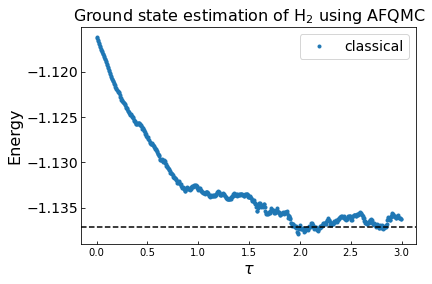

In [14]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(
    dtau * np.arange(num_steps),
    energies,
    linestyle="dashed",
    marker=".",
    color="tab:blue",
    linewidth=0,
    label="classical",
)
plt.axhline(-1.137117067345732, linestyle="dashed", color="black")
plt.title(r"Ground state estimation of H$_2$ using AFQMC", fontsize=16)
plt.legend(fontsize=14, loc="upper right")
plt.xlabel(r"$\tau$", fontsize=16)
plt.ylabel("Energy", fontsize=16)
plt.yticks(fontsize=14)
plt.tick_params(direction="in")
plt.show()

From the above results, we see that the imaginary time evolution converged near $\tau \approx 2.0$, although with statistical fluctuations. The fluctuations can be reduced by increasing the number of walker states.

### QAEE-AFQMC

As we can see from the eariler demonstration, in each step of the imaginary time evolution we need to execute several quantum circuits to estimate the overlaps and local energy for each walker state. This makes QC-AFQMC costly for both near-term quantum hardware and simulators. 

An alternative approach was suggested in [5] that only uses the quantum trial state $|\Psi_Q\rangle$ to evaluate the energy at the final stage of the algorithm, and performs purely classical AFQMC in all other steps of the algorithm. This approach is known as quantum-assisted energy evaluation (QAEE). The final energy is evaluated as

$$
E = \frac{\sum_{l=1}^N w_l\frac{\langle \Psi_Q|H|\phi_l\rangle}{\langle \Psi_C|\phi_l\rangle}}{\sum_{l=1}^N w_l \frac{\langle \Psi_Q|\phi_l\rangle}{\langle \Psi_C|\phi_l\rangle}}.
$$

We carry out the QAEE calculation in the next two cells and find the ground state of H$_2$. Note that the walker states are propagated according to the classical trial state, and only the energy is evaluated using the quantum trial state. We select a few time steps to perform the energy evaluation to reduce the time cost. The results will demonstate the advantage of using a quantum trial state.

Note that the quantum evaluations are only carried out on the times specified by `q_total_time`. If those times are not integer multiples of `dtau`, then the quantum step will never happen.

<div class="alert alert-block alert-info">
<b>Note:</b> The following cell of quantum AFQMC calculation will take  about 5 mins with 48 core parallelization. You may need to execute the notebook on a notebook instance with 48 or more CPU cores to utilize 48 core parallelization. We executed this notebook on a m5.24xlarge instance.
</div>

In [15]:
from afqmc.quantum_afqmc import quantum_afqmc

dtau = 0.005
num_steps = 600
num_walkers = 2000
quantum_evaluations_every_n_steps = 50

dev = qml.device("lightning.qubit", wires=4)

In [16]:
%%time

quantum_energies, energies = quantum_afqmc(
    num_walkers,
    num_steps,
    dtau,
    quantum_evaluations_every_n_steps,
    trial,
    prop,
    max_pool=48,
    dev=dev,
)

CPU times: user 2.12 s, sys: 962 ms, total: 3.08 s
Wall time: 3min 42s


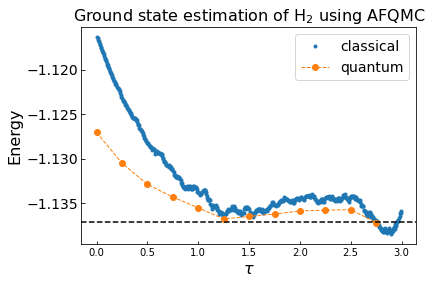

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(
    dtau * np.arange(num_steps),
    energies,
    linestyle="dashed",
    marker=".",
    color="tab:blue",
    linewidth=0,
    label="classical",
)
plt.plot(
    dtau * np.arange(0, num_steps, quantum_evaluations_every_n_steps),
    quantum_energies,
    linestyle="dashed",
    marker="o",
    color="tab:orange",
    linewidth=1,
    label="quantum",
)
plt.axhline(-1.137117067345732, linestyle="dashed", color="black")
plt.title(r"Ground state estimation of H$_2$ using AFQMC", fontsize=16)
plt.legend(fontsize=14, loc="upper right")
plt.xlabel(r"$\tau$", fontsize=16)
plt.ylabel("Energy", fontsize=16)
plt.yticks(fontsize=14)
plt.tick_params(direction="in")
plt.show()

In the above plot, the orange points are computed with the quantum evaluations. Because the quantum simulation is slower than classical, we use the regular classical simulator  in the green intermediate points. The purely classical results from the section above are shown in blue. 

From the above results, we can see that QAEE energy is more accurate than its classical counterpart, and has a smaller variance. For a full demonstration of the algorithm, we perform a full QAEE calculation over the whole imaginary time axis in the next section. 

## Scaling the computation with Amazon Braket Hybrid Jobs

With QAEE every fifty time steps, we can already see the benefit of QC-AFQMC. Now let's scale up AFQMC by increaing the number of quantum time steps in QAEE. With the increased number of time steps, the workload may take up to 30 minutes. For computationally intensive workloads like this one, we can leverage the managed experience of Amazon Braket Hybrid Jobs. A Braket hybrid job starts a job instance on AWS to run the algorithm code in the background, and termimates the instance once the workload is done. Here, we use Braket Jobs to run the QC-AFQMC algorithm, and retrieve the logs and results of the computation. 

We first prepare the algorithm script in the `run_q_afqmc.py` file. In addition to the algorithm, we also define metrics to monitor and the results to save. The next cell creates a Braket job for QC-AFQMC calculation.


<div class="alert alert-block alert-info">
<b>Note:</b> The following cell creates a Braket job for the QC-AFQMC calculation. The job will take about 30 mins on a ml.m5.24xlarge job instance, which will incur charge for about $2.8 USD. You may need to increase you quota limit to submit a Braket job with ml.m5.24xlarge instance. To learn more about Amazon Braket Hybrid Jobs, you can refer to the Amazon Braket <a href="https://docs.aws.amazon.com/braket/latest/developerguide/braket-what-is-hybrid-job.html">Developer Guide</a> and <a href="https://github.com/aws/amazon-braket-examples/tree/main/examples/hybrid_jobs">example notebooks</a>.
</div>

In [18]:
import time

import numpy as np
from braket.aws import AwsQuantumJob
from braket.jobs.config import InstanceConfig

job = AwsQuantumJob.create(
    device="local:pennylane/lightning.qubit",
    source_module="afqmc",
    entry_point="afqmc.run_q_afqmc:run",
    job_name=f"qaee-afqmc-" + str(int(time.time())),
    instance_config=InstanceConfig(instanceType="ml.m5.24xlarge"),
    hyperparameters={
        "num_walkers": 3000,
        "num_steps": 500,
        "dtau": 0.005,
        "quantum_evaluations_every_n_steps": 10,  # every 10 steps is a quantum evaluation
        "max_pool": 64,
    },
)

The following cell checks the state of the Braket job. You can also view the state in the "Jobs" tab in Amazon Braket Console.

In [19]:
print(job.state())

COMPLETED


When the job is completed, we can retrieve the QC-AFQMC results. 

In [20]:
result = job.result()
elapsed = result["elapsed"]
print(f"Elapsed time of job: {round(elapsed/60,1)} mins")

Elapsed time of job: 30.8 mins


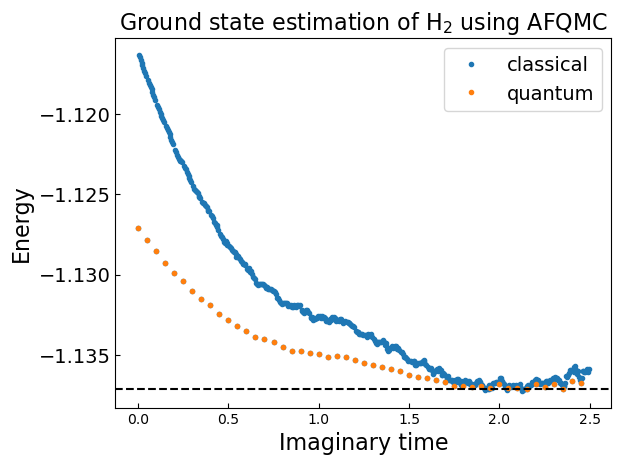

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.clf()
plt.plot(
    [0.005 * i for i in range(0, 500)],
    result["energies"],
    marker=".",
    color="tab:blue",
    linewidth=0,
    label="classical",
)
plt.plot(
    [0.005 * i for i in range(0, 500, 10)],
    result["quantum_energies"],
    marker=".",
    linewidth=0,
    color="tab:orange",
    label="quantum",
)
plt.axhline(-1.137117067345732, linestyle="dashed", color="black")
plt.title(r"Ground state estimation of H$_2$ using AFQMC", fontsize=16)
plt.legend(fontsize=14, loc="best")
plt.xlabel("Imaginary time", fontsize=16)
plt.ylabel("Energy", fontsize=16)
plt.yticks(fontsize=14)
plt.tick_params(direction="in")
plt.show()

In the plot of the computed ground-state energy of the H$_2$ molecule against imaginary time $\tau$ above, the curve labeled "classical" denotes the ground-state energy computed by using the classical trial state, i.e., the Hartree-Fock state. The curve labeled "quantum" denotes the ground-state energy computed using the QAEE-AFQMC algorithm on the PennyLane Simulator. The black dashed line represents the true ground state energy. We see that both classical and quantum methods converge to the correct value. However, the energies computed using QAEE-AFQMC have a smaller variance, demonstrating one of the main benefits of this approach.

## Conclusion


This notebook demonstrates how classical algorithms for quantum Monte Carlo can be augmented with quantum hardware. We explored a variant of QMC, auxiliary-field quantum Monte Carlo, which finds the ground state by performing a stochastic imaginary time evolution of an input state. This evolution is driven by computing the overlaps between a predefined trial state, and an ensemble of non-interacting walker states.

Using a quantum device, we can use a more flexible trial state, which may provide a better approximation to the ground state. We illustrated how the overlaps between the quantum trial state and classical walker states can be evaluated using quantum devices that can be accessed with Amazon Braket. 

We illustrated the classical and quantum AFQMC algorithms by applying them to the hydrogen molecule. Even for this toy system, the quantum assisted approach realized quantifiable benefits by reducing the variance of the calculated energy. 

We expect that for larger system sizes, QC-AFQMC will also reduce the bias in ground state energies compared to purely classical AFQMC (as observed in Refs. [4,5]). 

Overall, quantum-assisted quantum Monte Carlo is a new and interesting route to potentially achieve quantum advantage for chemical calculations.

## References

[1] Foulkes, W. M. C., et al. "Quantum Monte Carlo simulations of solids." [Reviews of Modern Physics 73.1 (2001): 33](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.73.33).

[2] Motta, Mario, and Shiwei Zhang. "Ab initio computations of molecular systems by the auxiliary‐field quantum Monte Carlo method." [Wiley Interdisciplinary Reviews: Computational Molecular Science 8.5 (2018): e1364](https://doi.org/10.1002/wcms.1364).

[3] Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." [Nature Communications 5.1 (2014): 1-7](https://www.nature.com/articles/ncomms5213?ref=https://githubhelp.com).

[4] Huggins, William J., et al. "Unbiasing fermionic quantum Monte Carlo with a quantum computer." [Nature 603.7901 (2022): 416-420](https://www.nature.com/articles/s41586-021-04351-z).

[5] Xu, Xiaosi, and Ying Li. "Quantum-assisted Monte Carlo algorithms for fermions." [arXiv:2205.14903 (2022)](https://arxiv.org/abs/2205.14903).

[6] Jiang, Zhang, et al. "Quantum algorithms to simulate many-body physics of correlated fermions." [Physical Review Applied 9.4 (2018): 044036](https://doi.org/10.1103/PhysRevApplied.9.044036).

[7] Huggins, William J., et al. "Efficient and noise resilient measurements for quantum chemistry on near-term quantum computers." [npj Quantum Information 7.1 (2021): 1-9](https://www.nature.com/articles/s41534-020-00341-7).

[8] Huggins, William J., et al. "A non-orthogonal variational quantum eigensolver." [New Journal of Physics 22.7 (2020): 073009](https://iopscience.iop.org/article/10.1088/1367-2630/ab867b).

[9] McArdle, Sam, et al. "Quantum computational chemistry." [Reviews of Modern Physics 92.1 (2020): 015003](https://doi.org/10.1103/RevModPhys.92.015003).

## Appendices

<a id=’Appendix_A’></a>

### Appendix A. Cholesky decomposition of the Hamiltonian

The Hamiltonian for molecular systems is usually written in second quantized form as:

$$
H = H_0 + \sum_{pq}\sum_{\sigma} h_{pq} a^{\dagger}_{p\sigma} a_{q\sigma} + \frac{1}{2}\sum_{pqrs}\sum_{\sigma \rho} V_{pqrs} a^{\dagger}_{p\sigma} a^{\dagger}_{q\rho} a_{r\rho} a_{s\sigma}.
$$

Note that the two-electron integral is stored as a rank four tensor written in the specific notation $V_{pqrs} = \langle pq|sr \rangle$. The idea of rewriting the Hamiltonian is to adopt the Cholesky decomposition. We rewrite the two-electron integral as:
$$
V_{pqrs} = V_{(ps), (rq)} = \sum_{\gamma}^{\Gamma} L^{\gamma}_{ps} L^{\gamma \ast}_{rq},
$$
which leads to the Hamiltonian:
$$
\begin{split}
H & = \sum_{pq}\sum_{\sigma} h_{pq} a^{\dagger}_{p\sigma} a_{q\sigma} + \frac{1}{2}\sum_{\gamma}^{\Gamma} \sum_{pqrs}\sum_{\sigma \rho} L^{\gamma}_{ps} L^{\gamma \ast}_{rq} a^{\dagger}_{p\sigma} a^{\dagger}_{q\rho} a_{r\rho} a_{s\sigma}\\
& = \sum_{pq}\sum_{\sigma} h_{pq} a^{\dagger}_{p\sigma} a_{q\sigma} - \frac{1}{2}\sum_{\gamma}^{\Gamma} \sum_{pqrs}\sum_{\sigma \rho} L^{\gamma}_{ps} L^{\gamma \ast}_{rq} a^{\dagger}_{p\sigma} (\delta_{qs} \delta_{\sigma \rho} - a_{s\sigma} a^{\dagger}_{q\rho}) a_{r\rho}\\
& = \sum_{pq}\left[h_{pq} - \frac{1}{2}\sum_{\gamma}^{\Gamma}\sum_{k} L^{\gamma}_{pk} L^{\gamma \ast}_{qk}\right] \sum_{\sigma} a^{\dagger}_{p\sigma} a_{q\sigma} + \frac{1}{2}\sum_{\gamma}^{\Gamma} \left[\sum_{ps}L^{\gamma}_{ps} \sum_{\sigma} a^{\dagger}_{p\sigma} a_{s\sigma}\right]^2.
\end{split}
$$

It's clearly seen that we have defined a modified one-body part:

$$
\hat{v}_0 = \sum_{pq}\left[h_{pq} - \frac{1}{2}\sum_{\gamma}^{\Gamma}\sum_{k} L^{\gamma}_{pk} L^{\gamma \ast}_{qk}\right] \sum_{\sigma} a^{\dagger}_{p\sigma} a_{q\sigma},
$$
and the Cholesky operator as 
$$
\hat{\mathcal{L}}_{\gamma} = \sum_{pq}L^{\gamma}_{pq} \sum_{\sigma} a^{\dagger}_{p\sigma} a_{q\sigma} = \sum_{pq} \sqrt{\lambda_{\gamma}} g^{\gamma}_{pq} \sum_{\sigma} a^{\dagger}_{p\sigma} a_{q\sigma}.
$$

Using the low rank decomposition function from OpenFermion, we are able to get the eigenvalues $\lambda$, the $g$ matrix and the one-body corrections. Note that the $\frac{1}{2}$ prefactor is not included in this function. To be consistent with the reference, the Hamiltonian is written as:
$$
H = H_0 + \hat{v}_0 - \frac{1}{2}\sum_{\gamma} \hat{v}_{\gamma}^2,\;\; \hat{v}_{\gamma} = i\hat{\mathcal{L}}_{\gamma}.
$$

To further reduce the variance of QMC sampling, we adopt mean-field subtraction, and rewrite the original Hamiltonian as follows:

$$
\hat{H} = \left(H_0 + \frac{1}{2}\sum_{\gamma} \overline{v}_{\gamma}^2\right) + \left(\hat{v}_0 - \sum_{\gamma} \hat{v}_{\gamma}\overline{v}_{\gamma}\right) - \frac{1}{2}\sum_{\gamma} (\hat{v}_{\gamma} -\overline{v}_{\gamma})^2
= H_0^{'} + \hat{v}_0^{'} - \frac{1}{2}\sum_{\gamma} \hat{v}_{\gamma}^{'2},\;\;\;\;\overline{v}_{\gamma} = \langle \hat{v}_{\gamma}\rangle_T.
$$

In this notebook we use this technique and have ignored the prime sign in the equations for simplicity.

<a id=’Appendix_B’></a>

### Appendix B. Imaginary Time Evolution

The AFQMC algorithm is a stochastic implementation of the imaginary time evolution. We want to implement the imaginary time evolution to obtain the ground state as:

$$
|\Psi\rangle \propto e^{-\tau (H-E_0)} |\Psi_I\rangle = \lim_{n \to \infty} \left[e^{-\triangle\tau(H-E_0)}\right]^n |\Psi_I\rangle.
$$

Since a direct implementation of the above formula is exponentially hard, we first adopt a Trotter approximation to the short-time propagator as

$$
e^{-\triangle \tau (H - E_0)} = e^{-\triangle \tau (H_0 - E_0)} e^{-\frac{\triangle\tau}{2} \hat{v}_0} \prod_{\gamma}^{N_{\gamma}} e^{\frac{\triangle\tau}{2} \hat{v}_{\gamma}^2}   e^{-\frac{\triangle\tau}{2} \hat{v}_0} 
$$

Then we adopt the Hubbard-Stratonovich (HS) transformation to map this interacting system onto many non-interacting systems coupled to a set of auxiliary fields $\textbf{x}$. Specifically, we have:

$$
e^{\frac{\triangle\tau}{2} \hat{v}_{\gamma}^2} = \int dx_{\gamma} \frac{1}{\sqrt{2\pi}}e^{-\frac{x_{\gamma}^2}{2}} e^{\sqrt{\triangle\tau} x_{\gamma} \hat{v}_{\gamma}}.
$$

Note that the HS transformation always holds within a complex-valued shift $\overline{\textbf{x}}$. So within the first-order Suzuki-Trotter approximation and importance sampling by taking the information of trial state into consideration, we can rewrite the imaginary propagator as:

$$
\begin{split}
e^{-\triangle\tau (H - E_0)} & = \int d\textbf{x} p(\textbf{x})B(\textbf{x}) = \int d\textbf{x} p(\textbf{x} - \overline{\textbf{x}}) B(\textbf{x} - \overline{\textbf{x}})\\
& = \int d\textbf{x} \left[\frac{1}{(2\pi)^{M/2}} e^{-(\textbf{x}-\overline{\textbf{x}})^2/2}\right] e^{-\frac{\triangle\tau}{2} \hat{v}_0} e^{\sqrt{\triangle\tau} \sum_{\gamma}(x_{\gamma} - \overline{x}_{\gamma}) \hat{v}_{\gamma}} e^{-\frac{\triangle\tau}{2} \hat{v}_0} e^{-\triangle\tau (H_0 - E_0)}\\
& = \int d\textbf{x} \frac{1}{(2\pi)^{M/2}} e^{-\textbf{x}^2/2} e^{\textbf{x}\cdot\overline{\textbf{x}} - \frac{\overline{\textbf{x}}^2}{2}} B(\textbf{x} - \overline{\textbf{x}}),
\end{split}
$$

where it is suggested to choose $\overline{\textbf{x}}$ as:
$$
\overline{\textbf{x}}_{\gamma} = -\sqrt{\triangle\tau} \langle \hat{v}_{\gamma}\rangle,\;\;\langle \hat{v}_{\gamma}\rangle = \frac{\langle \Psi_T |\hat{v}_{\gamma}|\phi_l \rangle}{\langle \Psi_T | \phi_l \rangle}.
$$

And the importance function is defined as:
$$
I(\textbf{x}, \overline{\textbf{x}}, \phi_l) = \frac{\langle \Psi_T|B(\textbf{x} - \overline{\textbf{x}})|\phi_l\rangle}{\langle \Psi_T|\phi_l\rangle} e^{\textbf{x}\cdot\overline{\textbf{x}} - \frac{\overline{\textbf{x}}^2}{2}} \approx e^{-\triangle\tau(\Re E^{\text{loc}}(\phi_l) - E_0)} \max(0, \cos\left[\arg\left(\frac{\langle \Psi_T|B(\textbf{x} - \overline{\textbf{x}})|\phi_l\rangle}{\langle \Psi_T|\phi_l\rangle}\right)\right]).
$$

In estimating $I(\textbf{x}, \overline{\textbf{x}}, \phi_l)$, we need to compute the local energy $E^{\text{loc}}(\phi_l) = \frac{\langle \Psi_T|\hat{H}|\phi_l\rangle}{\langle \Psi_T|\phi_l\rangle}$. 

As we've discussed, the trial state on classical computers is usually taken as either a mean-field state or a linear combination of mean-field states. The walker state, initially a Slater determinant (SD), remains on the manifold of Slater determinants. The two quantities that need to be estimated during the evolution are $\langle \Psi_T|\phi_l\rangle$ and $\langle \Psi_T|H|\phi_l\rangle$. We discuss about how to obtain the overlap and energy integral between two non-orthogonal SDs. In general we can represent arbitrary SDs as $(\Psi_{\uparrow}, \Psi_{\downarrow})$, where each component is a $M\times N^{\sigma}$ matrix. The overlap integral can be computed using:

$$
\langle \Psi| \Phi\rangle = \text{det}\left(\Psi_{\uparrow}^{\dagger} \Phi_{\uparrow}\right) \text{det}\left(\Psi_{\downarrow}^{\dagger} \Phi_{\downarrow}\right).
$$

We further define the one-particle and two-particle Green's function (assuming a restricted HF molecular orbital basis) to compute the energy:

$$
G^{\sigma}_{pq} = \frac{\langle \Psi|a^{\dagger}_{p\sigma} a_{q\sigma}|\Phi\rangle}{\langle \Psi| \Phi\rangle},\;\; \frac{\langle \Psi|a^{\dagger}_{p\sigma} a^{\dagger}_{q\rho} a_{r\rho} a_{s\sigma}|\Phi\rangle}{\langle \Psi| \Phi\rangle} = G^{\sigma}_{ps}G^{\rho}_{qr} - \delta_{\sigma\rho} G^{\sigma}_{pr} G^{\sigma}_{qs}
$$

The local energy can be computed using tensor contraction between the Green's functions and the Hamiltonian. 

<a id=’Appendix_C’></a>

### Appendix C. Compute $\langle \Psi_Q|\phi_l\rangle$ with vacuum reference circuit

The derivation follows that in Appendix C of Ref [5]. The first Hadamard and following CNOT gates of the vacuum reference circuit will prepare an entangled state

$$
|S\rangle = \frac{1}{\sqrt{2}} \left(|\Phi_r\rangle + |\Psi_{\text{HF}}\rangle \right).
$$

The unitary $V_{\phi}$ and $V_T$ will prepare the walker state and quantum trial state respectively. The CNOTs, denoted as unitary $\hat{A}$ before measurements, have the following effects:

$$
\hat{A}|0\rangle^{\otimes n_q} = |0\rangle^{\otimes n_q},\;\;\; \hat{A}|1\rangle\otimes|0\rangle^{\otimes (n_q-1)} = |\Psi_{\text{HF}}\rangle.
$$

The measurement is done in the $x$ or $y$ axis depending on the pre-rotations ($S$ gate), and the circuit effectively measures $\widetilde{X} = X\otimes |0\rangle\langle0|^{\otimes(n_q - 1)}$. Note that we have

$$
\hat{A} \widetilde{X} \hat{A}^{\dagger} = |\Psi_{\text{HF}}\rangle\langle \Phi_r| + |\Phi_r\rangle \langle\Psi_{\text{HF}}|,\;\;\; \langle \Phi_r|V_T^{\dagger}V_{\phi}|\Phi_r\rangle = 1,\;\;\; \langle \Phi_r|V_T^{\dagger}V_{\phi}|\Psi_{\text{HF}}\rangle = \langle \Psi_{\text{HF}}|V_T^{\dagger}V_{\phi}|\Phi_r\rangle = 0
$$

Therefore, the measurement yields the following:

$$
\langle\widetilde{X}\rangle = \langle S|V_{\phi}^{\dagger}V_T A \widetilde{X} A^{\dagger} V_T^{\dagger}V_{\phi}|S\rangle = \frac{1}{2}\left(\langle \Psi_{\text{HF}}|V_T^{\dagger}V_{\phi}|\Psi_{\text{HF}}\rangle + \text{h.c.}\right) = \Re{\langle\Psi_Q|\phi_l\rangle}.
$$

And the same logic applies to the measurement on $y$ axis.

<img src="images/vacuum_reference.png" width="800" />